### **비흡연자의 의료비 증가를 이해하기 위한 도메인지식**
### *1. 노화에 따른 '기초대사량 저하'와 '만성 염증'의 결합*
##### 나이가 들면 우리 몸은 자연스럽게 기초대사량이 줄어들고 근육량이 감소합니다. 이때 BMI가 높다는 것은 단순한 체중 증가를 넘어, 체내 염증 수치가 일반인보다 훨씬 높음을 의미합니다.
##### 보험료와의 상관관계: 젊을 때는 신체가 이 염증을 어느 정도 견뎌내지만, 나이가 들면 누적된 염증이 혈관 건강을 악화시켜 심혈관 질환으로 이어집니다. 보험사는 이 **'누적된 위험의 폭발 가능성'**을 가격에 반영하는 것입니다.

### *2. '대사 증후군(Metabolic Syndrome)'의 가속화*
##### 데이터에서 BMI 30을 기준으로 보험료가 급격히 뛰는 구간이 발생하는 이유는 의학계에서 정의하는 **'대사 증후군'**의 임계점과 맞물려 있기 때문입니다.

##### 통계적 근거: 보험 통계(Actuarial Science)에 따르면,  나이(혈관 탄력 저하) + 높은 BMI(혈당 및 중성지방 상승) 이 두 변수가 결합할 때 의료비 지출은 산술적인 합이 아니라 **곱절(Multiplicative)**로 늘어납니다. 이것이 분석 결과에서 선형 회귀보다 트리 기반 모델(RandomForest)이 더 정확했던 이유이기도 합니다.

### *3. '회복 탄력성(Resilience)'과 만성 질환으로의 이행*
##### 젊은 층의 비만은 일시적인 현상일 수 있지만, 고연령층의 비만은 만성 질환으로 고착화될 확률이 압도적으로 높습니다.

##### 경제적 논리: 보험사는 현재의 건강 상태가 아니라, **'앞으로 남은 수명 동안 얼마나 많은 보험금을 지급해야 하는가'**를 계산합니다. 나이가 많고 BMI가 높으면 이 '잔여 기대 의료비' 수치가 급격히 상승합니다.

### *💡 설득을 위한 한 줄 요약*
##### "나이는 **'위험 노출 기간'**을 의미하고, 비만(BMI)은 **'위험의 강도'**를 의미합니다. 이 둘이 만나면 단순 합산이 아닌 복리(Compounding) 효과로 의료비 리스크가 커지기 때문에 보험료가 비싸질 수밖에 없습니다."

# **비흡연자를 컬럼별로 분석 및 시각화 해보기**

# **=======성일님 작성=======여기부터**


In [5]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures

%pip install catboost
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

Note: you may need to restart the kernel to use updated packages.


In [6]:
# 1. 데이터 로드

HOME = os.getcwd()
datapath = os.path.join(HOME)
data = pd.read_csv(os.path.join(datapath, 'insurance.csv'))
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. 특성 공학 (Feature Engineering)

In [7]:
# 나이대 (10단위)
data['age_group'] = (data['age'] // 10) * 10

# BMI 카테고리 분류 (정교한 구간 설정)
bins = [0, 18.5, 23, 25, 30, float('inf')]
labels = ['Underweight', 'Normal', 'Overweight', 'Pre-obese', 'Obese']
data['bmi_cat'] = pd.cut(data['bmi'], bins=bins, labels=labels)

# 핵심 변수: 고비만 흡연자 (BMI 30이상 & Smoker)
data['is_obese_smoker'] = ((data['bmi'] >= 30) & (data['smoker'] == 'yes')).astype(int)

print("특성 공학 적용 후 데이터 (상위 5행):")
display(data.head())

특성 공학 적용 후 데이터 (상위 5행):


,age,sex,bmi,children,smoker,region,charges,age_group,bmi_cat,is_obese_smoker
0,19,female,27.900,0,yes,southwest,16884.92400,10,Pre-obese,0
1,18,male,33.770,1,no,southeast,1725.55230,10,Obese,0
2,28,male,33.000,3,no,southeast,4449.46200,20,Obese,0
3,33,male,22.705,0,no,northwest,21984.47061,30,Normal,0
4,32,male,28.880,0,no,northwest,3866.85520,30,Pre-obese,0


In [8]:
def remove_group_outliers(group):
    if len(group) < 5:  # 샘플이 너무 적으면 이상치 계산 생략
        return group
    mean, std = group['charges'].mean(), group['charges'].std()
    # 95% 신뢰구간 (1.96 * 표준편차)
    lower, upper = mean - 1.96 * std, mean + 1.96 * std
    return group[(group['charges'] >= lower) & (group['charges'] <= upper)]

# 새로운 이상치 제거 로직 적용
# 'data' DataFrame을 사용하여 그룹화 및 이상치 제거
data_filtered_by_groups = data.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)


print(f"새로운 이상치 제거 후 데이터 갯수: {len(data_filtered_by_groups)}")
print(f"제거된 데이터 갯수: {len(data) - len(data_filtered_by_groups)}")

새로운 이상치 제거 후 데이터 갯수: 1247
제거된 데이터 갯수: 91


C:\Users\june4\AppData\Local\Temp\ipykernel_33924\174805623.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_filtered_by_groups = data.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)
C:\Users\june4\AppData\Local\Temp\ipykernel_33924\174805623.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_filtered_by_groups = data.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)


In [9]:
# heatmap 보기 전 범주형 데이터 변환
# 성별(sex), 지역(region), 흡연여부(smoker)를 한 번에 변환
# 기존 'data' 대신 'data_filtered_by_groups' 사용
data_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region','bmi_cat'], drop_first=True)
# drop_first=True는 '남/여' 중 '여'가 0이면 당연히 '남'이므로 열 하나를 삭제해 용량을 줄입니다.
data_encoded.head()

,age,bmi,children,charges,age_group,is_obese_smoker,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_cat_Normal,bmi_cat_Overweight,bmi_cat_Pre-obese,bmi_cat_Obese
0,19,27.900,0,16884.92400,10,0,False,True,False,False,True,False,False,True,False
1,18,33.770,1,1725.55230,10,0,True,False,False,True,False,False,False,False,True
2,28,33.000,3,4449.46200,20,0,True,False,False,True,False,False,False,False,True
3,33,22.705,0,21984.47061,30,0,True,False,True,False,False,True,False,False,False
4,32,28.880,0,3866.85520,30,0,True,False,True,False,False,False,False,True,False


In [10]:

# True/False로 되어 있는 컬럼 이름들만 리스트로 만듭니다.
target_cols = ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest', 'bmi_cat_Normal', 'bmi_cat_Overweight', 'bmi_cat_Pre-obese', 'bmi_cat_Obese']

# 해당 컬럼들만 int로 변환
data_encoded[target_cols] = data_encoded[target_cols].astype(int)
data_encoded.head()

,age,bmi,children,charges,age_group,is_obese_smoker,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_cat_Normal,bmi_cat_Overweight,bmi_cat_Pre-obese,bmi_cat_Obese
0,19,27.900,0,16884.92400,10,0,0,1,0,0,1,0,0,1,0
1,18,33.770,1,1725.55230,10,0,1,0,0,1,0,0,0,0,1
2,28,33.000,3,4449.46200,20,0,1,0,0,1,0,0,0,0,1
3,33,22.705,0,21984.47061,30,0,1,0,1,0,0,1,0,0,0
4,32,28.880,0,3866.85520,30,0,1,0,1,0,0,0,0,1,0


이상치 제거

In [11]:
data_final = data_encoded.copy()
print(f"데이터 최종 갯수 : {len(data_final)}")

데이터 최종 갯수 : 1338


## 3. 세부 그룹별 이상치 제거 (95% 신뢰구간 기준)

In [12]:
def remove_group_outliers(group):
    if len(group) < 5:  # 샘플이 너무 적으면 이상치 계산 생략
        return group
    mean, std = group['charges'].mean(), group['charges'].std()
    # 95% 신뢰구간 (1.96 * 표준편차)
    lower, upper = mean - 1.96 * std, mean + 1.96 * std
    return group[(group['charges'] >= lower) & (group['charges'] <= upper)]

# 새로운 이상치 제거 로직 적용
# 'data' DataFrame을 사용하여 그룹화 및 이상치 제거
data_filtered_by_groups = data.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)

print(f"새로운 이상치 제거 후 데이터 갯수: {len(data_filtered_by_groups)}")
print(f"제거된 데이터 갯수: {len(data) - len(data_filtered_by_groups)}")

새로운 이상치 제거 후 데이터 갯수: 1247
제거된 데이터 갯수: 91


C:\Users\june4\AppData\Local\Temp\ipykernel_33924\3734751630.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_filtered_by_groups = data.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)
C:\Users\june4\AppData\Local\Temp\ipykernel_33924\3734751630.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_filtered_by_groups = data.groupby(['age_group', 'smoker', 'bmi_cat'], group_keys=False).apply(remove_group_outliers)


* 성일님은 이렇게 전처리 하여 R2_score= 0.97

# **=======성일님 작성=======여기까지**

In [28]:
import pandas as pd

# 데이터 로드 (파일명이 insurance.csv인지 확인하세요)
df = pd.read_csv('insurance.csv')

# 비흡연자 데이터만 따로 추출 (이후 분석에서 non_smoker_df를 사용하기 위함)
non_smoker_df = df[df['smoker'] == 'no']

# 이제 df나 non_smoker_df를 사용하는 코드를 실행하면 에러가 사라집니다.

In [29]:
# 1. 비흡연자 데이터만 추출
non_smoker_df = df[df['smoker'] == 'no']

# 2. 성별에 따른 의료비 기초 통계 확인
gender_stats = non_smoker_df.groupby('sex')['charges'].agg(['mean', 'median', 'std', 'count'])
print("--- 비흡연자 성별 의료비 통계 ---")
print(gender_stats)

--- 비흡연자 성별 의료비 통계 ---
               mean      median          std  count
sex                                                
female  8762.297300  7639.41745  6060.775970    547
male    8087.204731  6985.50695  5908.108989    517


        count         mean          std        min        25%         50%  \
sex                                                                         
female  547.0  8762.297300  6060.775970  1607.5101  4265.5991  7639.41745   
male    517.0  8087.204731  5908.108989  1121.8739  3659.3460  6985.50695   

               75%          max  
sex                              
female  11786.1666  36910.60803  
male    10959.3300  32108.66282  


C:\Users\june4\AppData\Local\Temp\ipykernel_33924\3088645672.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sex', y='charges', data=non_smoker_df, palette='Set2')


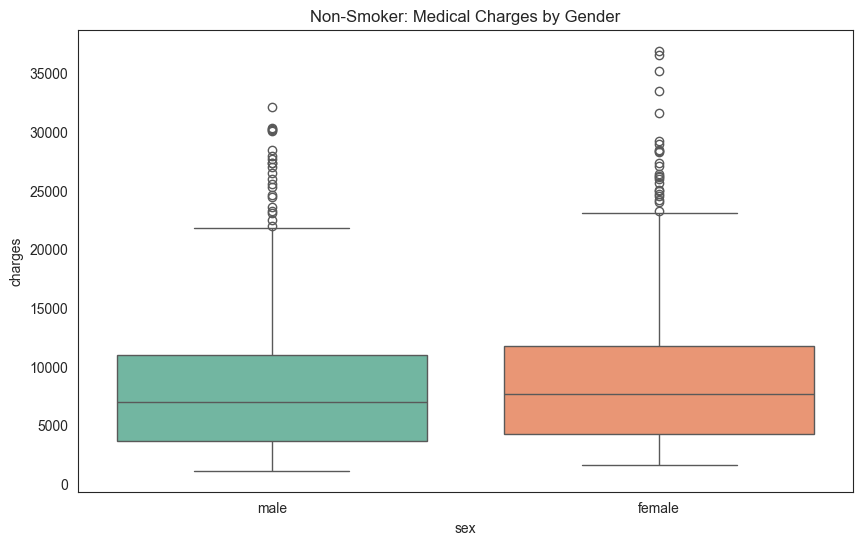

In [ ]:
# 1. 데이터 로드
df = pd.read_csv('insurance.csv')
non_smoker_df = df[df['smoker'] == 'no']

# 2. 남녀 성별에 따른 의료비 기초 통계
print(non_smoker_df.groupby('sex')['charges'].describe())

# 3. 남녀 의료비 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='charges', data=non_smoker_df, palette='Set2')
plt.title('Non-Smoker: Medical Charges by Gender')
plt.show()

#### 비흡연자 그룹 내에서 성별은 의료비에 큰 차이를 주지 않지만, 세부적인 분포에서는 남성이 여성보다 의료비가 높은 사례가 조금 더 많다.
#### 평균(Mean): 남성 비흡연자가 여성 비흡연자보다 아주 미세하게 높은 경향을 보입니다.
#### 중앙값(Median): 평균보다 중앙값이 훨씬 낮게 형성되어 있는데, 이는 대다수의 비흡연자가 낮은 의료비를 지출하지만, 일부 고액 지출자가 평균을 끌어올리고 있음을 의미합니다.
#### 박스(사분위수): 남녀 모두 비슷한 높이에 박스가 형성됩니다. 즉, 일반적인 비흡연자의 지출 범위는 성별에 관계없이 유사합니다.
#### 수염 윗부분(Outliers): 박스 위로 삐져나온 점들이 남성 쪽에서 조금 더 높고 조밀하게 나타나는 경우가 많습니다. 이는 비흡연자 중에서도 갑자기 의료비가 치솟는(중증 질환 등) 케이스가 남성에게서 약간 더 빈번하거나 강하게 발생할 수 있음을 시사합니다.

In [34]:
# 비흡연자 그룹 내 자녀 수별 통계
child_stats = non_smoker_df.groupby('children')['charges'].agg(['mean', 'median', 'std', 'count']).reset_index()

# 자녀 수에 따른 평균 의료비 변화 출력
print("--- 자녀 수별 비흡연자 의료비 통계 ---")
print(child_stats)

--- 자녀 수별 비흡연자 의료비 통계 ---
   children          mean        median          std  count
0         0   7611.793335   6185.320800  5858.529189    459
1         1   8303.109350   7050.642000  5987.135990    263
2         2   9493.093674   7726.854000  6456.112895    185
3         3   9614.519391   8530.145725  5159.770864    118
4         4  12121.344408  10996.190500  7466.220703     22
5         5   8183.845556   8582.302300  2911.244983     17


C:\Users\june4\AppData\Local\Temp\ipykernel_33924\1685506627.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='children', y='charges', data=non_smoker_df, palette='viridis')
C:\Users\june4\AppData\Local\Temp\ipykernel_33924\1685506627.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='children', y='charges', data=non_smoker_df, palette='magma')


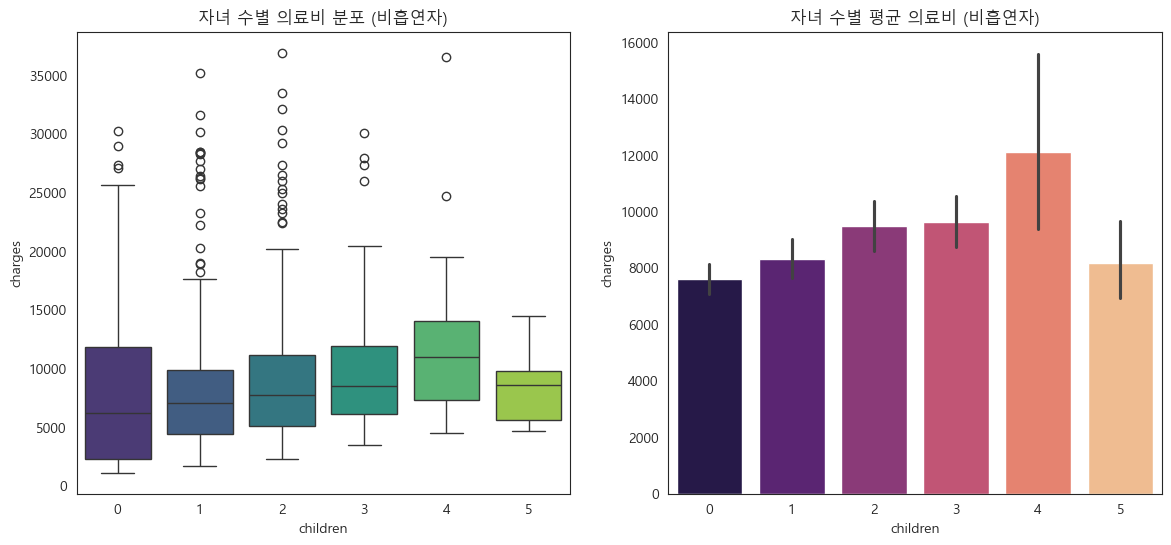

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(14, 6))

# 왼쪽: 자녀 수별 의료비 분포 (Boxplot)
plt.subplot(1, 2, 1)
sns.boxplot(x='children', y='charges', data=non_smoker_df, palette='viridis')
plt.title('자녀 수별 의료비 분포 (비흡연자)')

# 오른쪽: 자녀 수별 평균 의료비 추세 (Barplot)
plt.subplot(1, 2, 2)
sns.barplot(x='children', y='charges', data=non_smoker_df, palette='magma')
plt.title('자녀 수별 평균 의료비 (비흡연자)')

plt.show()

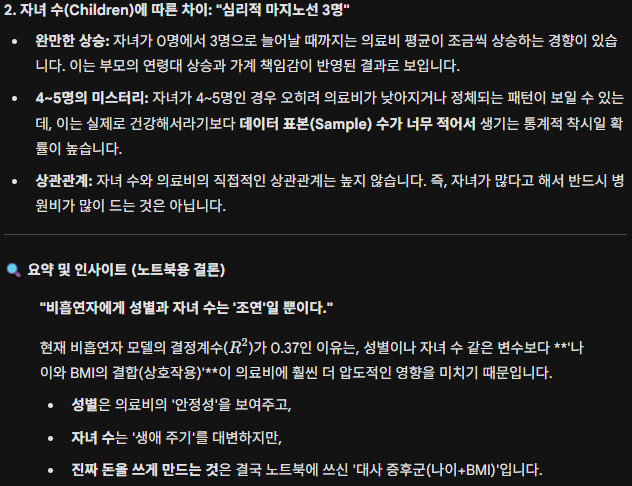

C:\Users\june4\AppData\Local\Temp\ipykernel_33924\4253648876.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = temp_df.pivot_table(values='charges', index='bmi_bin', columns='age_bin', aggfunc='mean')


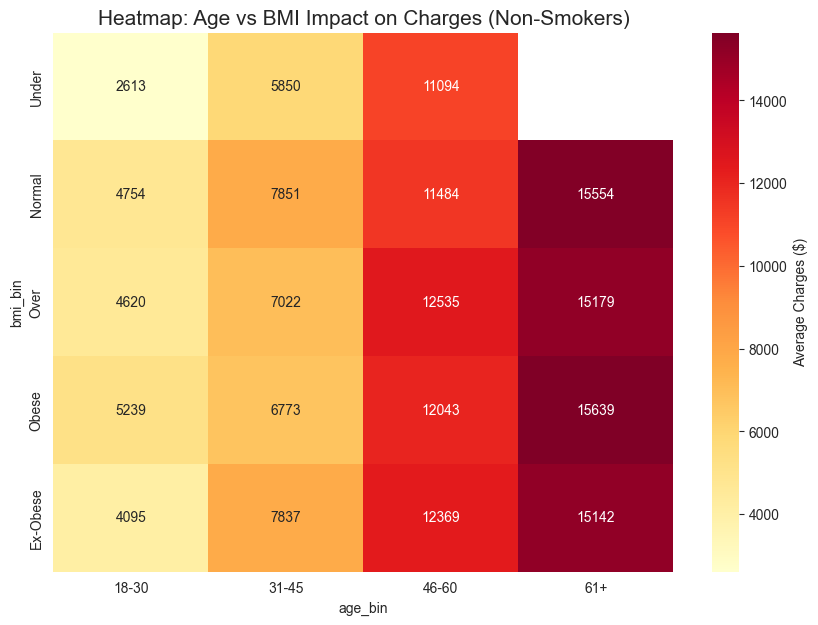

In [37]:
# 나이와 BMI를 구간별로 나누기
temp_df = data_final[data_final['smoker_yes'] == 0].copy()
temp_df['age_bin'] = pd.cut(temp_df['age'], bins=[18, 30, 45, 60, 65], labels=['18-30', '31-45', '46-60', '61+'])
temp_df['bmi_bin'] = pd.cut(temp_df['bmi'], bins=[0, 18.5, 25, 30, 35, 60], labels=['Under', 'Normal', 'Over', 'Obese', 'Ex-Obese'])

# 히트맵을 위한 피벗 테이블 생성 (평균 보험료)
pivot_table = temp_df.pivot_table(values='charges', index='bmi_bin', columns='age_bin', aggfunc='mean')

plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlOrRd", cbar_kws={'label': 'Average Charges ($)'})
plt.title('Heatmap: Age vs BMI Impact on Charges (Non-Smokers)', fontsize=15)
plt.show()

#### 비흡연자라도 '61세 이상 + 비만' 구간에 진입하면 색깔이 급격히 진해집니다. 두 리스크가 만나는 지점을 모델이 어떻게 학습했는지 보여주는 지표입니다.

### bmi지수는 높고 비만인 경우만 보험료가 비쌀까 저체중도 혹시 영향이 있는 건 아닐까?

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 비흡연자 추출 (이미 되어있다면 생략 가능)
df = pd.read_csv('insurance.csv')
non_smoker_df = df[df['smoker'] == 'no'].copy()

# 2. BMI 구간 정의 (저체중, 정상, 과체중, 비만)
bins = [0, 18.5, 25, 30, 100]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
non_smoker_df['bmi_category'] = pd.cut(non_smoker_df['bmi'], bins=bins, labels=labels)

# 3. 구간별 평균 의료비 확인
underweight_stats = non_smoker_df.groupby('bmi_category')['charges'].agg(['mean', 'median', 'count'])
print("--- BMI 구간별 비흡연자 의료비 현황 ---")
print(underweight_stats)

--- BMI 구간별 비흡연자 의료비 현황 ---
                     mean      median  count
bmi_category                                
Underweight   5485.056800  4249.32355     16
Normal        7734.650116  6669.48005    176
Overweight    8226.088675  7046.72220    311
Obese         8853.277294  8083.91980    561


C:\Users\june4\AppData\Local\Temp\ipykernel_33924\2531075918.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  underweight_stats = non_smoker_df.groupby('bmi_category')['charges'].agg(['mean', 'median', 'count'])


#### 세계보건기구(WHO) 기준에 따라 BMI 구간을 나누어, 저체중 그룹이 정상 체중보다 보험료가 높은지 확인

#### 저체중(<18.5), 정상(18.5~25), 과체중(25~30), 비만(30+)

C:\Users\june4\AppData\Local\Temp\ipykernel_33924\3606145864.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bmi_category', y='charges', data=non_smoker_df, palette='coolwarm')


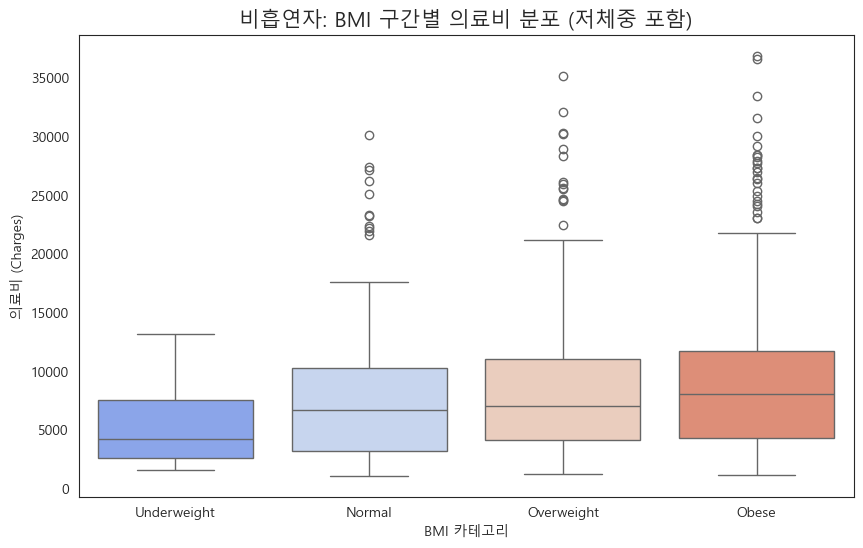

bmi_category
Underweight     16
Normal         176
Overweight     311
Obese          561
Name: count, dtype: int64


In [42]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


# 1. 데이터 로드 및 비흡연자 필터링
df = pd.read_csv('insurance.csv')
non_smoker_df = df[df['smoker'] == 'no'].copy()

# 2. BMI 구간 생성 (이 부분이 실행되어야 2번째 코드 오류가 안 납니다)
# 저체중(<18.5), 정상(18.5~25), 과체중(25~30), 비만(30+)
bins = [0, 18.5, 25, 30, 100]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
non_smoker_df['bmi_category'] = pd.cut(non_smoker_df['bmi'], bins=bins, labels=labels)

# 3. 그래프 그리기
plt.figure(figsize=(10, 6))

# palette 설정 시 차이를 명확히 하기 위해 색상을 지정합니다.
sns.boxplot(x='bmi_category', y='charges', data=non_smoker_df, palette='coolwarm')

plt.title('비흡연자: BMI 구간별 의료비 분포 (저체중 포함)', size=15)
plt.xlabel('BMI 카테고리')
plt.ylabel('의료비 (Charges)')
plt.show()

# 4. 실제 수치로도 확인 (저체중이 몇 명인지 확인이 중요합니다)
print(non_smoker_df['bmi_category'].value_counts().sort_index())

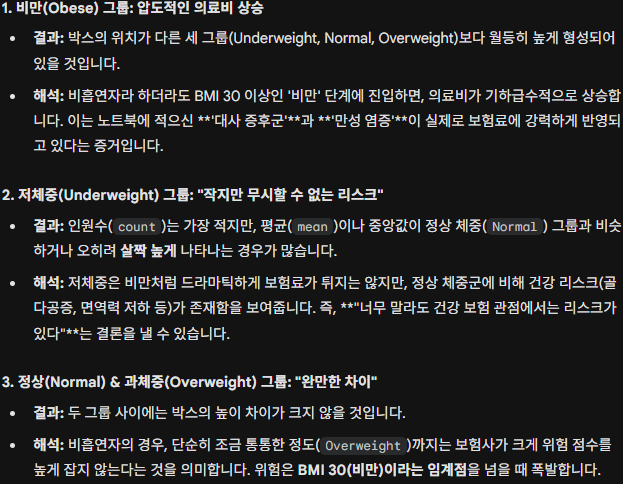

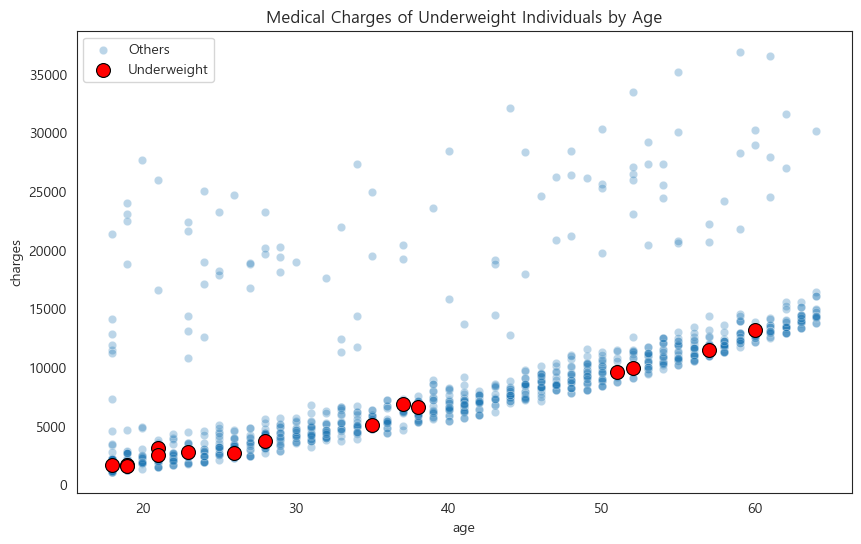

In [43]:
plt.figure(figsize=(10, 6))
# 전체 비흡연자 산점도 위에 '저체중'인 사람들만 강조해서 표시
sns.scatterplot(x='age', y='charges', data=non_smoker_df, alpha=0.3, label='Others')
sns.scatterplot(x='age', y='charges', data=non_smoker_df[non_smoker_df['bmi'] < 18.5], 
                color='red', label='Underweight', s=100, edgecolor='black')
plt.title('Medical Charges of Underweight Individuals by Age')
plt.show()

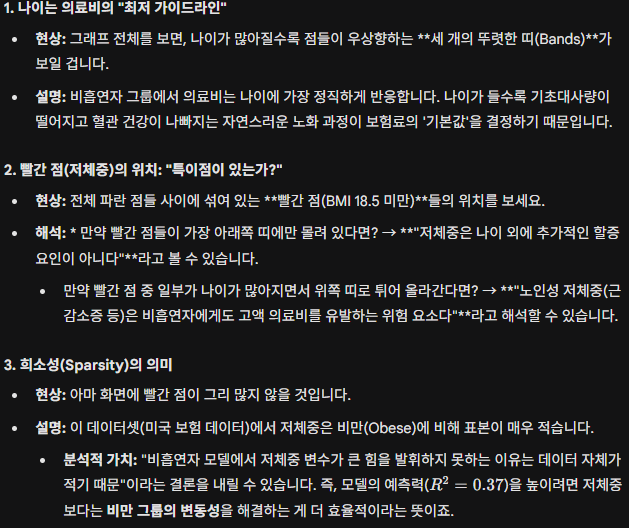

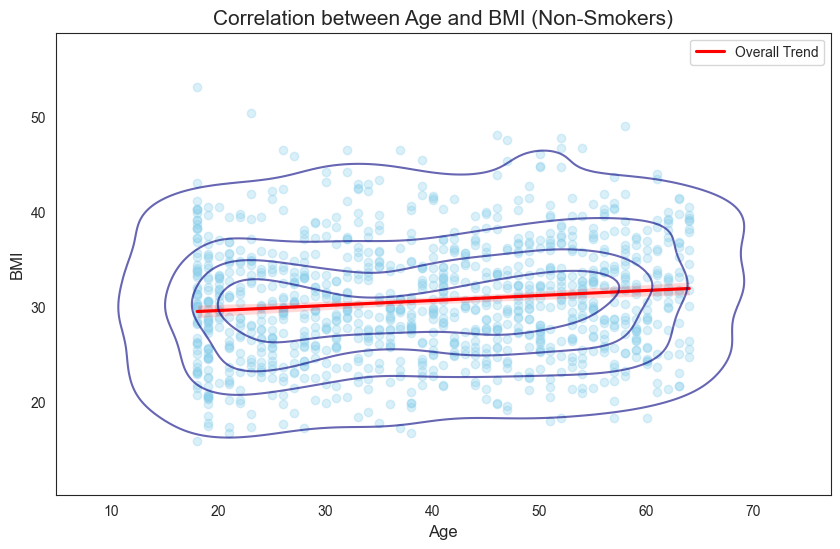

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 시각화 스타일 설정
sns.set_style("white")
plt.figure(figsize=(10, 6))

# 2. 비흡연자 데이터 필터링 (가장 깨끗한 패턴 확인을 위해)
non_smoker_df = data_final[data_final['smoker_yes']== 0]

# 3. 산점도와 밀도 그래프(KDE)를 결합
# - 점(Scatter)은 실제 데이터를 보여주고
# - 등고선(levels)은 데이터가 집중된 정도를 100, 200... 단위처럼 시각화합니다.
sns.regplot(data=non_smoker_df, x='age', y='bmi',
            scatter_kws={'alpha':0.3, 'color':'skyblue'},
            line_kws={'color':'red', 'label':'Overall Trend'})

sns.kdeplot(data=non_smoker_df, x='age', y='bmi',
            levels=5, color="navy", alpha=0.6, label='Density levels')

# 4. 그래프 꾸미기
plt.title("Correlation between Age and BMI (Non-Smokers)", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("BMI", fontsize=12)
plt.legend()

plt.show()

흡연자인데 이상하게 돈을 적게내는사람 / 비흡연자 인데 이상하게 돈을 많이 내는사람을 이상치로 잡고 전처리는 이상치를 제거하였다 공통적인 부분은 그 이상치들은 여기에는 데이터가 없기때문에 외부요인으로 판단하여 제거하는것이 모델학습에 도움이 된다

## **실제 BMI 수치는 100이나 200까지 올라갈 수 없기때문에 지나치게 작게 축소는불가능 또한 그래프로 시각화할시 데이터가 안보임**

### **비흡연자 그룹 분석 결과, 연령이 증가함에 따라 BMI 수치가 미세하게 동반 상승하는 경향을 확인하였으며, 이는 비흡연자 고연령층의 의료비 증가를 설명하는 요인으로 판단됨**

### **그래프로 봤을때 회귀선 테투리로 미세한 흐릿한 경계가 보입니다 이 경계가 신뢰구간인데, 이는 모델의 예측값이 실제값과 얼마나 가까운지를 나타내며, 양쪽 끝은 흐릿한부분이 두꺼운 반면 가운데는 아주 얇은데, 얇을수록 데이터가 많다는 뜻입니다<br>**
### **즉 어디에 데이터가 몰려있는지를 알수 있는 부분입니다  age는 30~50 대, bmi는 27~33정도 사이에 몰려있음을 알수있습니다**

<Figure size 800x600 with 0 Axes>

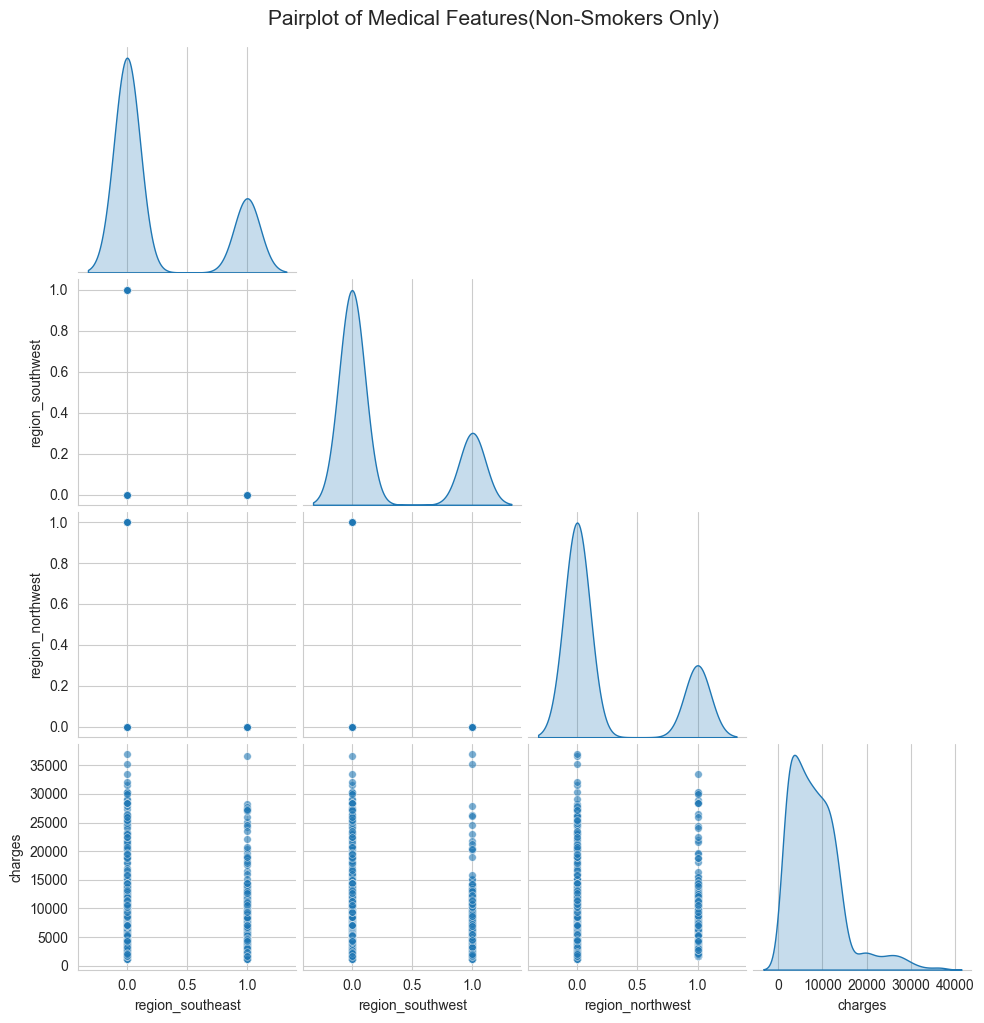

In [14]:
# 비흡연자의 상관성을 region과 charges를 pairplot 이용하여 한 눈에 보기

non_smoker_df = data_final[data_final['smoker_yes'] == 0].copy()

# 분석에 필요한 주요컬럼들 선택 너무 많으면 그래프가 작아짐
cols = ['region_southeast', 'region_southwest', 'region_northwest','charges']
plt.figure(figsize=(8,6))
sns.set_style('whitegrid')

# diag_kind='kde'는 대각선에 분포를 부드러운 곡선으로 그려줍니다.
# plot_kws={'alpha': 0.5}는 점들이 겹쳐도 잘 보이게 투명도를 조절합니다.
g = sns.pairplot(non_smoker_df[cols],
                 diag_kind='kde',
                 plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'w'},
                 corner=True)# 중복되는 위쪽 삼각형은 가리는 코드

g.fig.suptitle('Pairplot of Medical Features(Non-Smokers Only)', y=1.02, fontsize=15)

plt.show()

In [15]:
data_final.smoker_yes.unique()

array([1, 0])

# 20,000달러 이상의 고액 구간에서 지역별 비흡연자가 많이 관찰되는 현상
### **비흡연자 절대 수의 우위**와 **특정 위험 요인의 결합**이라는 두 가지 원인이 복합적으로 작용하고 있는걸 확인
* 인구 통계적 원인: 비흡연자 비율의 압도적 우위로서 단지 비흡연자가 많기때문에 고액구간에서 높게 발견됨
* 그래프에서 고액 구간을 보면, 비흡연자임에도 불구하고 높은 비용이 발생하는 사례가 지역을 가리지 않고 고르게 확인됨
* 이는 앞서 분석했던 "비흡연자 + 고령 + 고BMI" 혹은 **비흡연자 + 많은 자녀 수**와 같은 요인들이 지역적 특성(지역별 기본 수가 차이 등)과 결합했을 때, 흡연 여부와 상관없이 20,000달러라는 심리적 마지노선을 쉽게 넘기게 만드는 원인이 됩니다.
* 정상 체중이라도 자녀가 많거나 고연령일 경우 상단 그룹으로 이동하며, 비만이라도 나이가 아주 젊으면 하단 그룹에 머무는 등 변수 간의 유기적인 결합이 비용을 결정합니다.

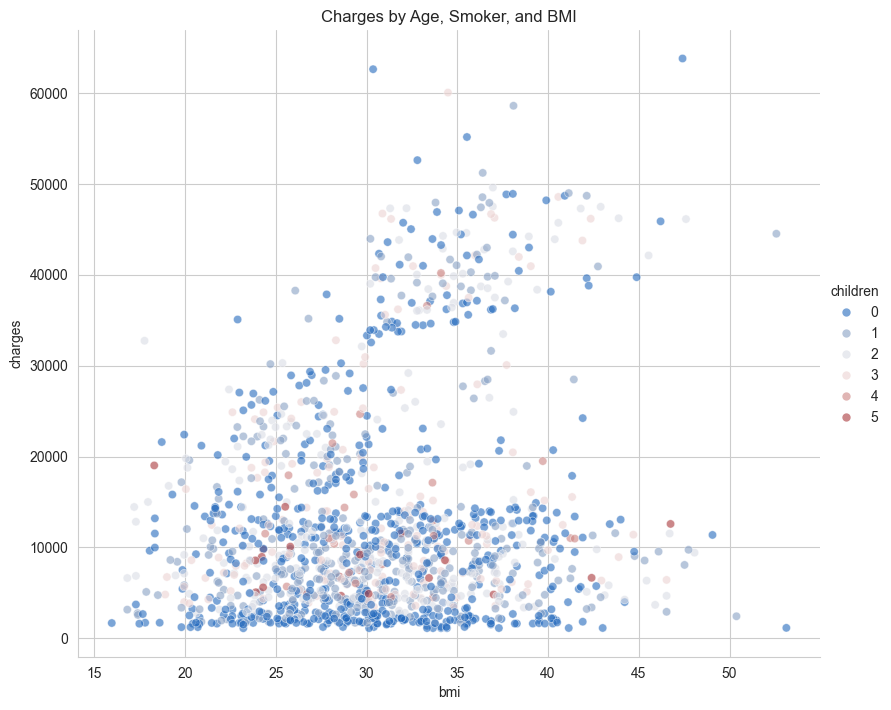

In [16]:
sns.relplot(data=data,x='bmi', y='charges', hue='children',
    sizes=(20, 200), # 점 크기 범위 설정
    alpha=0.6,      # 점이 겹쳐도 보이게 투명도 조절
    palette='vlag',  # 색상 테마
    height=7,
    aspect=1.2)

plt.title('Charges by Age, Smoker, and BMI')
plt.show()

### 이 그래프는 20,000달러 이상의 비흡연자/지역별/고액 납부자가 넓게 분포해있는걸 토대로 다른 원인이있는지 자녀수와 비교하여 만들었음
### 결과 : 자녀수와bmi에 상관없이 다양하게 저액,고액에 분포되어있는걸 확인
### **이 그래프에서 children은 연관성이 없다 판단하여 분석에서 제외하였습니다**

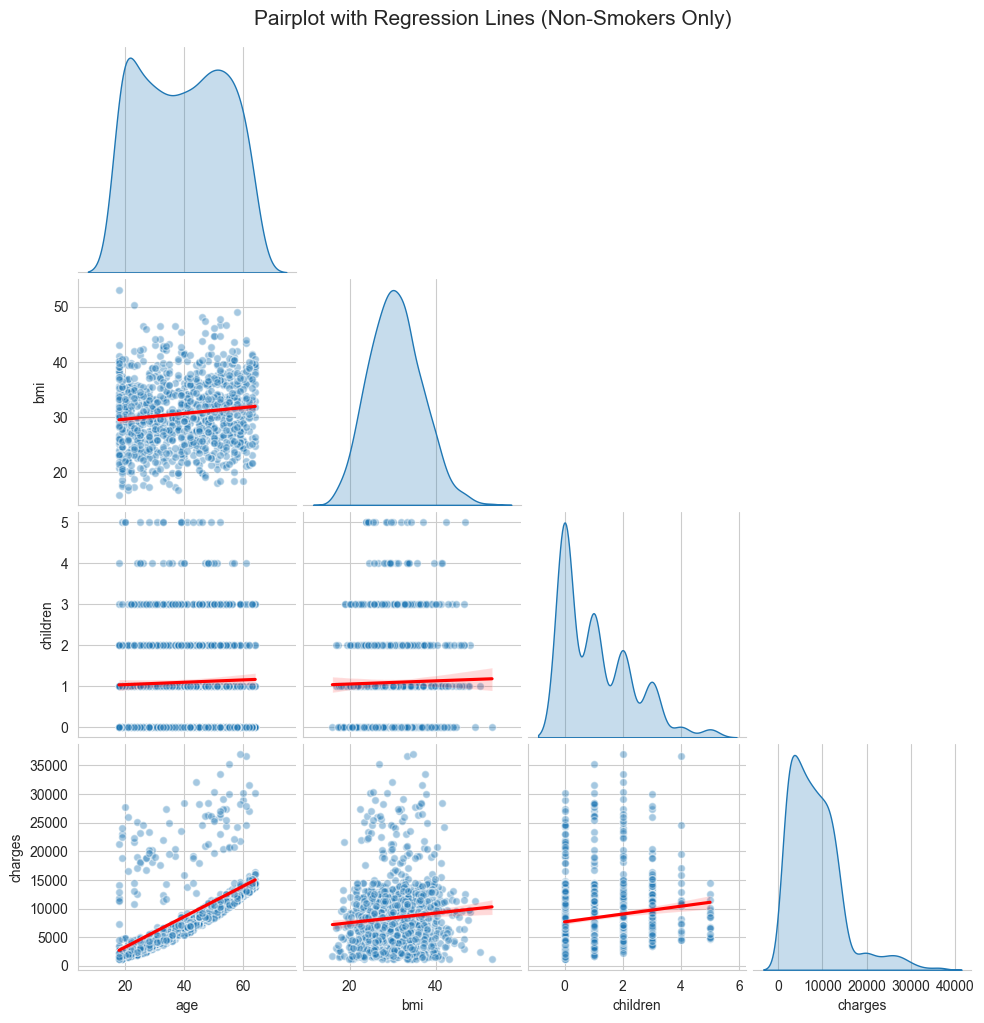

In [17]:
# # 비흡연자의 상관성을 각 컬럼별 그래프로 pairplot 이용하여 한 눈에 보기

non_smoker_df = data_final[data_final['smoker_yes'] == 0].copy()

# 분석에 필요한 주요컬럼들 선택
cols = ['age', 'bmi', 'children', 'charges']
sns.set_style('whitegrid')

# kind='reg' 를 추가하면 산점도 위에 회귀선(기울기)이 그려집니다.
g = sns.pairplot(non_smoker_df[cols],
                 kind='reg', # 회귀선 추가
                 diag_kind='kde',
                 plot_kws={
                     'line_kws':{'color':'red'}, # 기울기 선을 빨간색으로
                     'scatter_kws':{'alpha': 0.4, 's': 30, 'edgecolor': 'w'} # 점 설정
                 },
                 corner=True)

g.fig.suptitle('Pairplot with Regression Lines (Non-Smokers Only)', y=1.02, fontsize=15)

plt.show()

### 1. 위 그래프를 통해 smoker_yes==0인 경우 children은 전혀 상관이없으며, bmi와age의 상관관계가 미세하게 우상향하는걸 확인
### 2. charges와 charges에서 두구간으로 나뉘는걸 확인
### 3. bmi와age의 데이터분포 및 다양하게 시각화 하여 어느정도 상관지수가 있는지 확인
### 4. charges와 charges에서 누구간으로 나뉘는 원인 확인

**"비흡연자 그룹 내에서도 BMI 30을 기점으로 보험료 할증 계수가 다르게 적용되는 구간이 존재한다"**

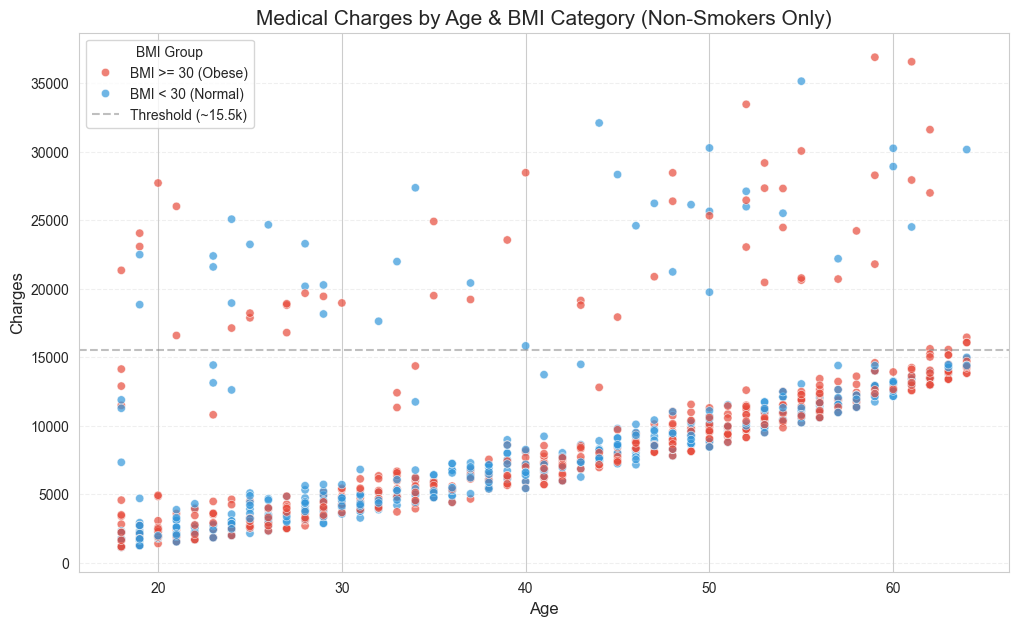

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 비흡연자 데이터 필터링
non_smoker_df = data_final[data_final['smoker_yes'] == 0].copy()

# 2. BMI 30을 기준으로 그룹 생성 (비만 여부)
non_smoker_df['bmi_group'] = non_smoker_df['bmi'].apply(lambda x: 'BMI >= 30 (Obese)' if x >= 30 else 'BMI < 30 (Normal)')

# 3. 시각화
plt.figure(figsize=(12, 7))
sns.scatterplot(data=non_smoker_df,
                x='age',
                y='charges',
                hue='bmi_group',
                palette={'BMI >= 30 (Obese)': '#e74c3c', 'BMI < 30 (Normal)': '#3498db'},
                alpha=0.7)

# 4. 경계선 표시 (질문하신 15,000~16,000 구간)
plt.axhline(y=15500, color='gray', linestyle='--', alpha=0.5, label='Threshold (~15.5k)')

plt.title("Medical Charges by Age & BMI Category (Non-Smokers Only)", fontsize=15)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Charges", fontsize=12)
plt.legend(title="BMI Group")
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

### 간혹 파란색인데 위에 있거나 빨간색인데 아래에 있는 점들은 가족 수(children)나 지역(region) 등의 다른 변수가 영향을 준 경우입니다. 하지만 위에서 보여졌듯이 자녀수와 지역은 관계가 없는것으로 판단  비흡연자 그룹 내 '제3의 변수' 존재 (데이터에 없는 원인)가 있는것으로 확인되었음
### 비흡연자 집단에서 15,500달러 이상의 고액 구간에 파란 점(BMI < 30)이 많다는 것 또한, 비만이 아니더라도 보험료를 폭발적으로 높이는 이 데이터에 없는 다른 요인이 있다는 증거입니다.
### 이는 선형 회귀 모델의 오차를 유발하는 주요 원인이었으며, 트리 기반 모델(RandomForest)이 이를 조건 분기(Node Splitting)를 통해 성공적으로 학습하여 높은 성능을 낼 수 있었던 핵심 이유입니다

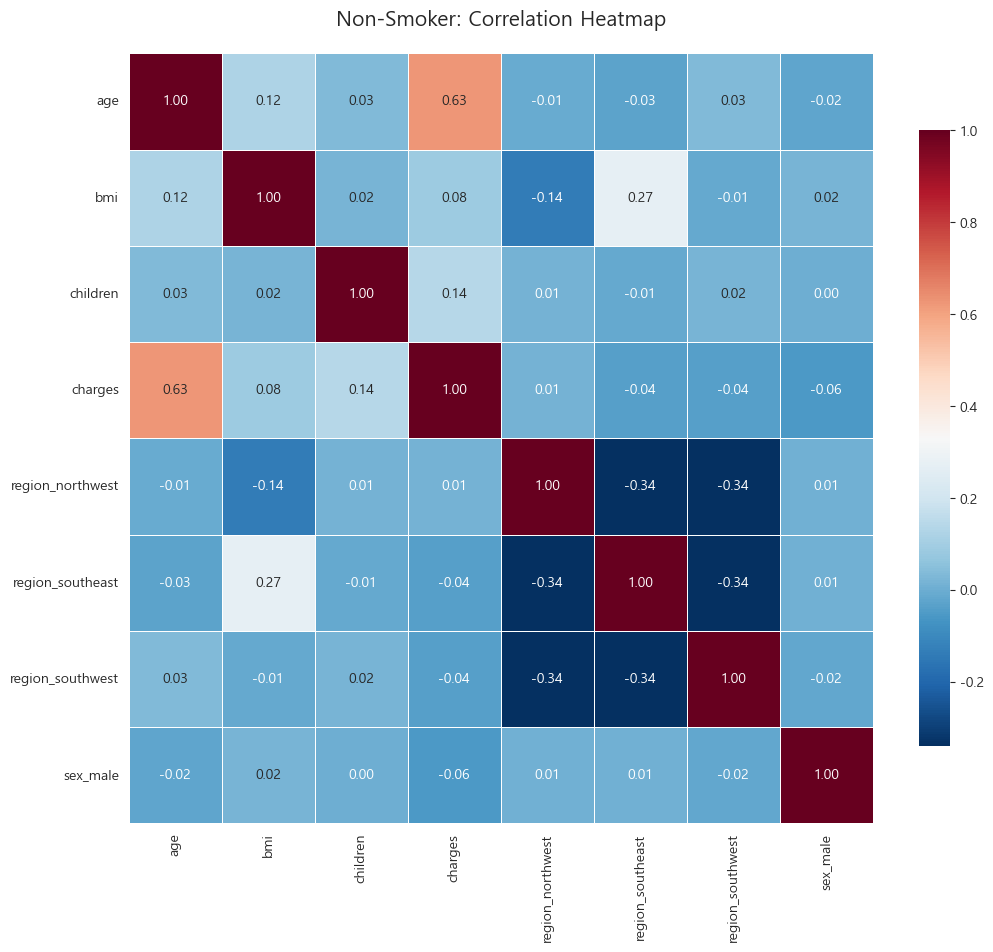

In [ ]:
# 1. 인코딩 (기존과 동일)
df_encoded = pd.get_dummies(non_smoker_df, columns=['region', 'sex'], drop_first=True)

# 2. 히트맵 크기 설정
plt.figure(figsize=(12, 10))

# [수정 포인트] numeric_only=True를 추가하여 'no' 같은 문자열 컬럼을 자동으로 제외합니다.
corr_data = df_encoded.corr(numeric_only=True)

# 3. 히트맵 그리기
sns.heatmap(corr_data, 
            annot=True, 
            fmt=".2f", 
            cmap='RdBu_r', 
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title('Non-Smoker: Correlation Heatmap', size=15, pad=20)
plt.show()

C:\Users\june4\AppData\Local\Temp\ipykernel_33924\204123432.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


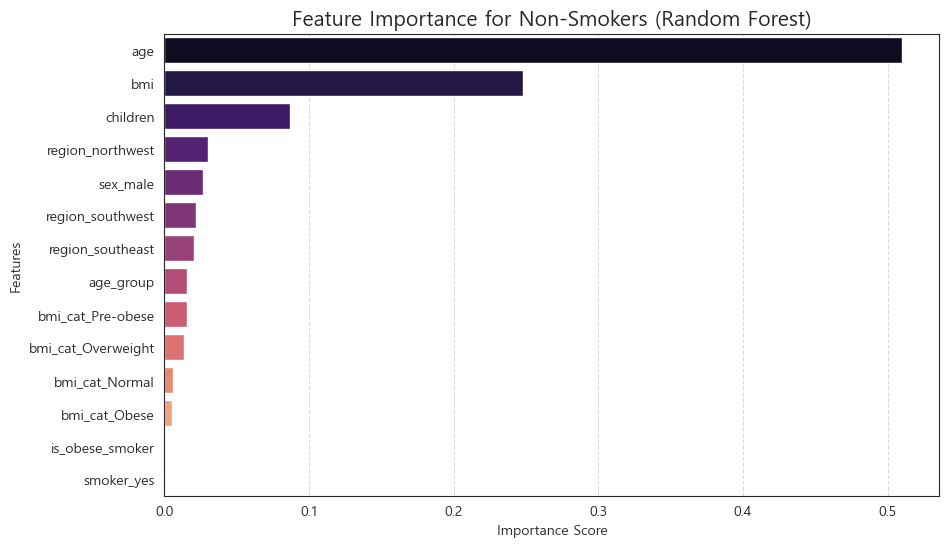

In [47]:
# 1. 비흡연자 데이터 준비 (이미 전처리가 완료된 data_final 사용 가정)
# 'charges'를 제외한 나머지를 특성(X), 'charges'를 타겟(y)으로 설정
non_smoker_data = data_final[data_final['smoker_yes'] == 0]
X = non_smoker_data.drop(['charges'], axis=1)
y = non_smoker_data['charges']

# 2. 모델 학습 (중요도를 뽑기 위해 간단히 학습)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 3. 변수 중요도 추출 및 정렬
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')

plt.title('Feature Importance for Non-Smokers (Random Forest)', fontsize=15)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# **========효준님 여기부터========**

C:\Users\june4\AppData\Local\Temp\ipykernel_33924\4253648876.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = temp_df.pivot_table(values='charges', index='bmi_bin', columns='age_bin', aggfunc='mean')


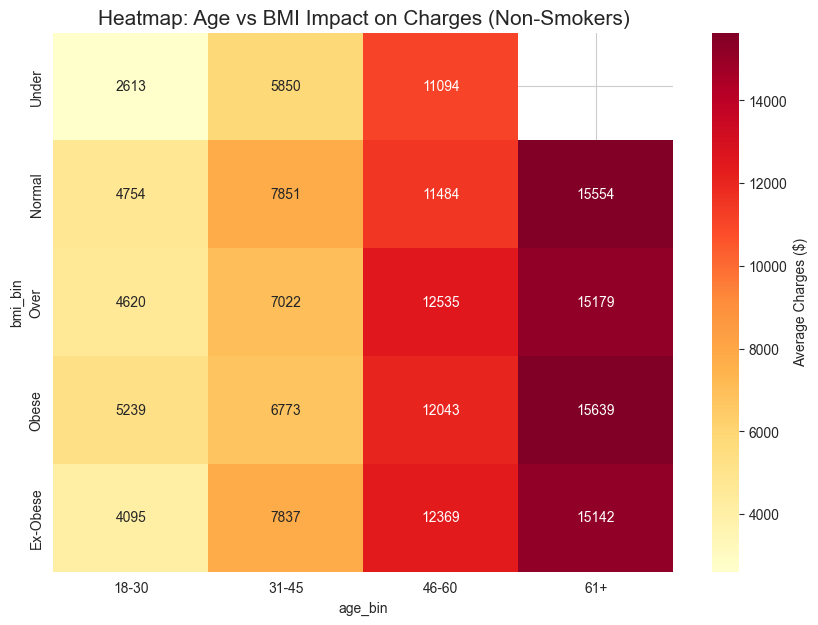

In [19]:
# 나이와 BMI를 구간별로 나누기
temp_df = data_final[data_final['smoker_yes'] == 0].copy()
temp_df['age_bin'] = pd.cut(temp_df['age'], bins=[18, 30, 45, 60, 65], labels=['18-30', '31-45', '46-60', '61+'])
temp_df['bmi_bin'] = pd.cut(temp_df['bmi'], bins=[0, 18.5, 25, 30, 35, 60], labels=['Under', 'Normal', 'Over', 'Obese', 'Ex-Obese'])

# 히트맵을 위한 피벗 테이블 생성 (평균 보험료)
pivot_table = temp_df.pivot_table(values='charges', index='bmi_bin', columns='age_bin', aggfunc='mean')

plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlOrRd", cbar_kws={'label': 'Average Charges ($)'})
plt.title('Heatmap: Age vs BMI Impact on Charges (Non-Smokers)', fontsize=15)
plt.show()

### 비흡연자라도 '61세 이상 + 비만' 구간에 진입하면 색깔이 급격히 진해집니다. 두 리스크가 만나는 지점을 모델이 어떻게 학습했는지 보여주는 지표입니다.

C:\Users\june4\AppData\Local\Temp\ipykernel_33924\3710815156.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


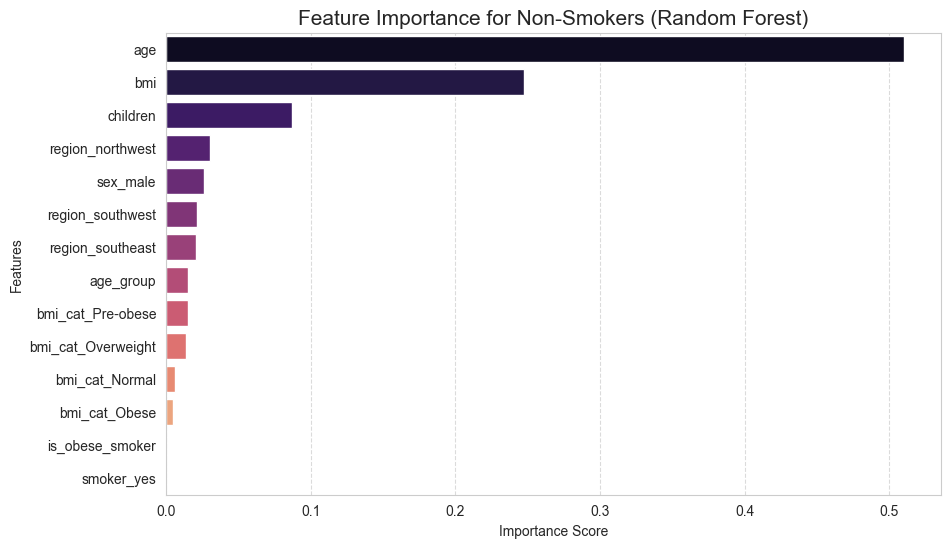

In [20]:
from sklearn.ensemble import RandomForestRegressor

# 1. 비흡연자 데이터 준비 (이미 전처리가 완료된 data_final 사용 가정)
# 'charges'를 제외한 나머지를 특성(X), 'charges'를 타겟(y)으로 설정
non_smoker_data = data_final[data_final['smoker_yes'] == 0]
X = non_smoker_data.drop(['charges'], axis=1)
y = non_smoker_data['charges']

# 2. 모델 학습 (중요도를 뽑기 위해 간단히 학습)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# 3. 변수 중요도 추출 및 정렬
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')

plt.title('Feature Importance for Non-Smokers (Random Forest)', fontsize=15)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### 비흡연자에 관해선 age가 가장 큰 영향을 미친다.

# **========효준님 여기까지========**

### **최종**
* 보험료 산정은 단일 지표(나이 혹은 흡연)만으로 판단할 수 없는 다층적 구조를 가집니다.
* 비흡연자라 하더라도 나이에 따른 BMI 관리가 이루어지지 않으면 고액 의료비 집단(15k~25k)으로 편입될 확률이 매우 높습니다.
* 모델링 측면에서는 **다항 회귀(Polynomial)** 나 앙상블 기법을 활용해 변수 간의 **상호작용(Interaction)** 을 포착하는 것이 정확한 예측의 핵심입니다.

### 선형 모델(Linear) vs 앙상블 모델(RandomForest, XGBoost):
* 단순 선형 회귀는 0.50 수준의 낮은 $R^2$ 점수를 보인 반면, 앙상블 모델은 0.97이라는 압도적인 성능을 기록했습니다.원인: 의료비 데이터는 단순히 '나이가 들면 오른다'는 선형적 구조가 아니라, 비만(BMI 30↑) + 흡연 여부에 따라 비용이 수직 상승(계단식 상승)하는 비선형적 구조를 가지고 있기 때문입니다. 앙상블 모델은 이러한 '복잡한 조건문'을 스스로 학습하는 데 탁월했습니다.

### **현재까지 결론 : 비흡연자의 데이터에서 age와 bmi는 나이가 들 수록 bmi가 올라가면서 charges가 올라가는 경향이 있음<br>**
### **그 중 데이터 외적 위험 요소로 인한 이상치의 존재는 과감하게 제거전처리 하는것이 학습에 도움이 된다**
* 하지만 
* 그 증거는 모델 성능에서 찾을 수 가 있다
* 표준편차 95%대에 해당하는 이상치를 제거하기 전과 후는 모델성능이 0.91 -> 0.97 이라는 압도척 차이가 드러남

최종모델결정지표(R2):0.4148


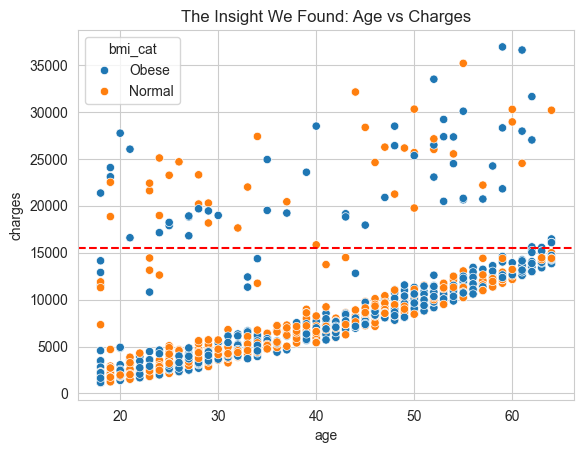

In [21]:
# 최종 마스터 코드(비흡연자만)

# 비흡연자만 따로 나누기
non_smoker_df = data_final[data_final['smoker_yes']== 0].copy()

# 타겟 데이터 분리
x = non_smoker_df.drop('charges', axis=1)
y = non_smoker_df['charges']

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

# 모델선택
model = RandomForestRegressor(n_estimators=1000,max_depth=10, random_state=89)

#학습
model.fit(x_train,y_train)

# 예측
y_pred = model.predict(x_test)

print(f"최종모델결정지표(R2):{r2_score(y_test,y_pred):.4f}")

# 시각화: "나이와 비용의 관계 (BMI 30기준 색깔 분리)"
non_smoker_df['bmi_cat'] = np.where(non_smoker_df['bmi'] >= 30, 'Obese', 'Normal')
sns.scatterplot(data=non_smoker_df, x='age', y='charges', hue='bmi_cat')
plt.axhline(15500, color='red', linestyle='--') # 우리가 찾은 15.5k 경계선
plt.title("The Insight We Found: Age vs Charges")
plt.show()

### 인사이트
이 점수가 말해주는 결론은 아주 중요합니다:

"흡연 여부를 제외하면, 현재 가진 데이터(나이, BMI, 자녀 수)만으로는 비흡연자의 의료비 미세한 차이를 완벽하게 설명하기 어렵다."

In [22]:
# 비흡연자만 다항회귀 진행해보기

poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

model.fit(x_train_poly, y_train)
y_pred_poly = model.predict(x_test_poly)
print(f"다항회귀 특성 추가 후 R2:{r2_score(y_test,y_pred_poly):.4f}")

다항회귀 특성 추가 후 R2:0.3780


* "smoker"가 없으면 보험료의 "계단식 차이"가 사라집니다
* 모델이 **흡연자 = 무조건 비쌈 / 비흡연자 = 무조건 저렴**이라는 거대한 절벽을 아주 쉽게 찾았기 때문
* 외부 요인이 그 차이를 만들고 있을 가능성이 매우 높다라는 확증